In [38]:
import pandas as pd
import numpy as np
import re
import string
import stopwords
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

## Daten laden

In [28]:
# load text-data and labels
df = pd.read_json("testset.json")
df = df[["transcript", "gattung"]].copy()
df["gattung"] = df["gattung"].apply(lambda x: ' '.join(x))

,transcript,gattung
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage
...,...,...
1356,"Da hüpft ein kleines Roboterbein im Kreis, es ...",Bericht
1357,Noch ziemlich entspannt muss ich sagen ich kan...,Bericht
1358,"Seit der hier für die Rabattaktion Nein, bishe...",Bericht
1359,"Ich bin Leon Schäfer, 27 Jahre alt, Paar, Leic...",Bericht


In [29]:
# load and add embeddings
embeddings = pd.read_json("embeddings.json")
df["embedding"] = embeddings.apply(lambda row: ', '.join(row.astype(str)), axis=1)

In [30]:
df.head()

,transcript,gattung,embedding
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07..."
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0..."
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208..."
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06..."
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -..."


## EDA & Preprocessing

In [31]:
df.describe(include='object')

,transcript,gattung,embedding
count,1361,1361,1361
unique,1344,8,1344
top,,Statement,"-0.030148252844810004, -0.005122783593833001, ..."
freq,18,200,18


In [32]:
# are there items without genre value
balance_counts = df.groupby("gattung")["gattung"].agg("count")
balance_counts 

gattung
                              1
Bericht                     194
Bericht in Interviewform    200
Glosse                      191
Interview                   182
Reportage                   198
Statement                   200
Umfrage                     195
Name: gattung, dtype: int64

Die Fehlende Gattung ist ein Statement, das wird hier korrigiert

In [33]:
index = df[df["gattung"] == ""].index.tolist()
df.loc[index,["gattung"]] = "Statement"

In [34]:
balance_counts = df.groupby("gattung")["gattung"].agg("count")
balance_counts 

gattung
Bericht                     194
Bericht in Interviewform    200
Glosse                      191
Interview                   182
Reportage                   198
Statement                   201
Umfrage                     195
Name: gattung, dtype: int64


Hier werden einfach nur Dinge gezählt:

In [35]:
def word_count(text):
    return len(text.split(" "))

def char_count(text):
    return len(text)

def avr_sentence_length(text):
    sentences = text.split(".")
    lengths = [len(sentence) for sentence in sentences]
    mean = np.asarray(lengths).mean().round(2)
    return mean

df["word_count"] = df["transcript"].apply(word_count)
df["char_count"] = df["transcript"].apply(char_count)
df["avr_sentence_length"] = df["transcript"].apply(avr_sentence_length)
df.head()

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77


In [46]:
def plot_count_by_category(char_count_by_category, count_label):
    plt.figure(figsize=(6, 4))
    #plt.figure(figsize=(10, 6))
    char_count_by_category.plot(kind='bar', color='skyblue')
    plt.title(f'{count_label} pro Gattung')
    plt.xlabel('Gattung')
    plt.ylabel(count_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

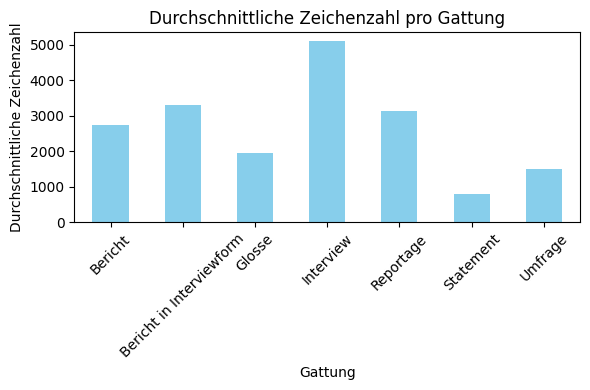

In [47]:
char_count_by_category = df.groupby("gattung")["char_count"].agg("mean").round(0)
plot_count_by_category(char_count_by_category, "Durchschnittliche Zeichenzahl")

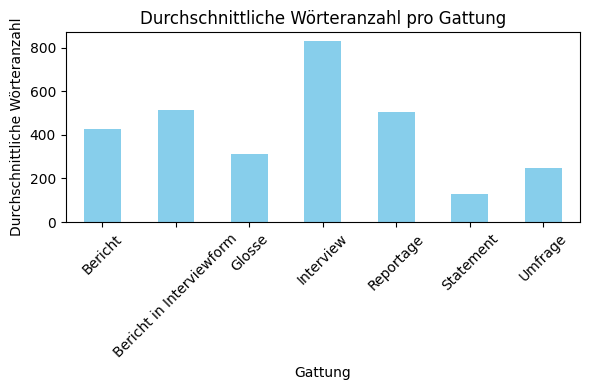

In [48]:
word_count_by_category = df.groupby("gattung")["word_count"].agg("mean").round(0)
plot_count_by_category(word_count_by_category, "Durchschnittliche Wörteranzahl")

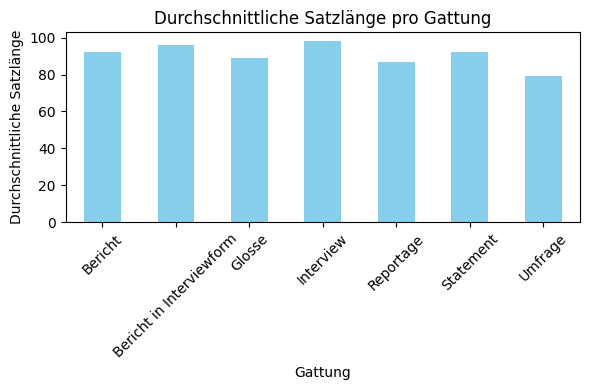

In [49]:
sentence_length_by_category = df.groupby("gattung")["avr_sentence_length"].agg("mean").round(0)
plot_count_by_category(sentence_length_by_category, "Durchschnittliche Satzlänge")

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'Average sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

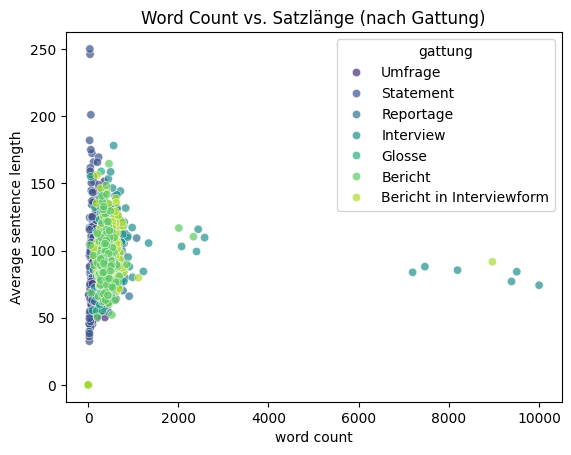

In [50]:
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="Average sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Hier gibt es einige üble Ausreißer, wie damit umgehen?

1. Kürze das Transcript überlanger Texte auf die Durchschnittslänge der jeweiligen Kategorie

In [53]:
def truncate_long_text(text, category):
    words = text.split(" ")
    if len(words) < 3000:
        return text
    else:
        return " ".join(words[:word_count_by_category[category].astype(int)])

df["transcript"] = df.apply(lambda row: truncate_long_text(row["transcript"],row["gattung"]), axis=1)
df["word_count"] = df["transcript"].apply(word_count)
df["char_count"] = df["transcript"].apply(char_count)
df["avr_sentence_length"] = df["transcript"].apply(avr_sentence_length)

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'avarage sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

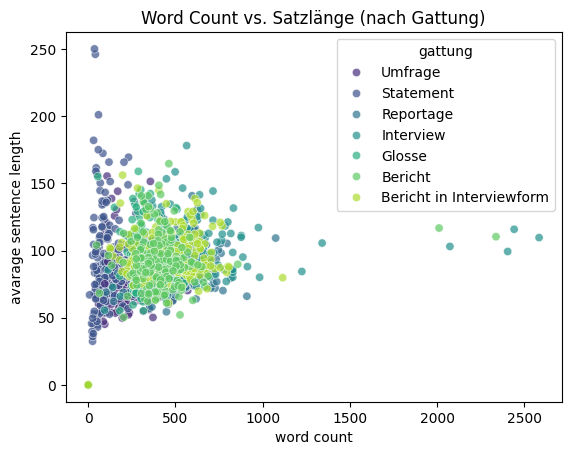

In [54]:
# Scatterplot mit Seaborn (handhabt Kategorien automatisch)
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="avarage sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Besser! Betrachte die Ausreißer auf der Y-Achse

In [58]:
df[df["avr_sentence_length"] > 220]

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length
240,Ich hatte wirklich einfach starke Probleme mit...,Statement,"0.041820656508207, 0.015210284851491002, -0.01...",42,246,246.0
334,Jetzt haben wir einen Geisterkrankenhaus daste...,Statement,"-0.008378626778721001, 0.033959086984395, -0.0...",37,250,250.0


In [60]:
df.iloc[240]["transcript"]

'Ich hatte wirklich einfach starke Probleme mit den Lungen und von daher bin ich unheimlich stolz auf meine Leistung, weil ich denke, das muss erst mal jemand schaffen, so gehandicapt an den Start zu gehen und dann noch eine Silbermedaille da raus'

Liegt vermutlich am vermehrten Rauschen im Transkript von Statement (keine geübten Sprecher*innen). Ich lasse es erstmal so.

In [66]:
small_sentence_length = df[df["avr_sentence_length"] < 25]
small_sentence_length.head()

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length
227,,Statement,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0
228,,Statement,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0
255,,Statement,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0
626,,Interview,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0
628,,Interview,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0


Hier liegen die Dinge ohne Mining-Transkript. Die müssen entfernt werden:

In [76]:
df = df.drop(small_sentence_length.index).copy()
df.shape

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'avarage sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

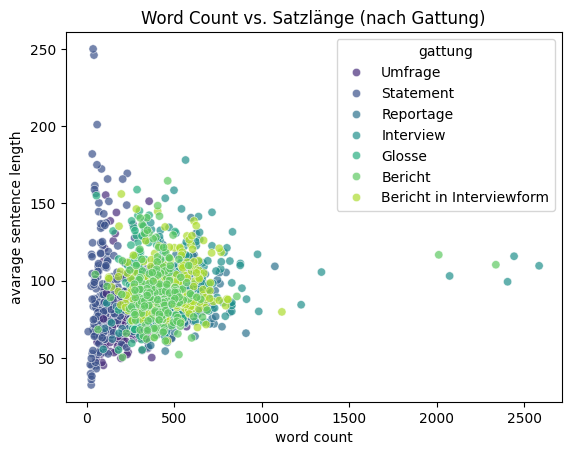

In [78]:
# Scatterplot mit Seaborn (handhabt Kategorien automatisch)
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="avarage sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Besser! Jetzt das transcript entschlacken

**Stopwörter entfernen**

In [80]:
def clean(text):
    text = str(text).lower()
    text = re.sub("-"," ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

df["clean_text"] = df["transcript"].apply(clean)
df.loc[1]["clean_text"]

'he ute ist weltknuddeltag was es nicht alles gibt weltknuddeltag existiert schon seit 38 jahren und wurde ins leben gerufen und leuten vor augen zu führen wie wichtig so eine kurze umarmung so ein kurzes knuddeln fürs wohlbefinden sein kann unser reporter jens alenia hat nachgehakt und gefragt wann haben sie denn das letzte mal geknuddelt und wen mein mann meine freundin mein freund ist knüller mir von meiner oma mutter vater tante cousine großtante da kommt es ja aus dem knuddel nicht mehr raus das ist auch gut so meine freundin deren mann knuddel ist wie knuddeln den mann ihrer freunde ja natürlich wir sind uns sehr lange vertraute freunde ein bisschen körperkontakt muss schon sein auf jeden fall also schob ein teddybär den ich gern knuddele jeden abend eine bettdecke gibt es irgendeine bekannte persönlichkeit die sie ger ne mal knuddeln würden j taylor swift justin timberlake vielleicht denen würde ich knuddeln ja alle so süß ist ich glaub fremde leute knuddelt ich gar nicht so ger

In [82]:
stop_words = stopwords.get_stopwords("de")

def remove_stopwords(text):
    return " ".join([word for word in text.split(" ") if word not in stop_words])

df["text_stopwordless"] = df["clean_text"].apply(remove_stopwords)
df.head()

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...


**Tokenisieren**

In [86]:
!python -m spacy download de_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 5.9 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')


In [87]:
nlp = spacy.load('de_core_news_md')

In [88]:
def tokenize(text):
    doc = nlp(text)
    tokens = [tok.text for tok in doc]
    return tokens

df["tokens"] = df["transcript"].progress_apply(tokenize)
df.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1343/1343 [01:10<00:00, 19.09it/s]


,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie..."
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic..."
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine..."
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe..."
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel..."


**Lemmatisieren**

In [89]:
def lemmatize(text):
     doc = nlp(text)
     return " ".join([x.lemma_ for x in doc])

df["text_lemmatized"] = df["text_stopwordless"].progress_apply(lemmatize)
df.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1343/1343 [00:40<00:00, 33.50it/s]


,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens,text_lemmatized
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie...",letzter Bundestagswahl sein absolut Umfragehoc...
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic...",he ute Weltknuddeltag alle geben Weltknuddelta...
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine...",47 elf grrrls Wasser haben Mutter immer kaufen...
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe...",meinen Atmosphäre Endeffekt gehören leute alle...
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel...",gestern abend groß Familienfest vielleicht ihn...


100%|██████████| 1360/1360 [01:14<00:00, 18.31it/s]
C:\Users\janfs\AppData\Local\Temp\ipykernel_9284\1472405454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lemmatized"] = df["text_stopwordless"].progress_apply(lemmatize)


**Hier kann man den Dataframe direkt laden, um sich in Zukunft das Preprocessing zu sparen!**

In [91]:
# load dataframe to save time
try:
    df.to_pickle("lemmatized.pkl")
except:
    df = pd.read_pickle("lemmatized.pkl")

#df = pd.read_pickle("lemmatized.pkl")

## Test verschiedener Modelle

Hier wird ein Bag of Words Ansatz versucht. Es macht einen erheblichen Unterschied, wie der max_features Wert bei der Vektorisierung gewählt wird, auch abhängig vom Modell. Tendenziell zeigt sich, dass die Ergebnisse etwas besser werden, wenn man die Stopwords drin lässt.

**BoW erstellen und mit PCA analysieren:**

In [94]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=4000)

X = vectorizer.fit_transform(df["clean_text"])

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# PCA durchführen (auf 2D reduzieren)
svd = TruncatedSVD(n_components=2, random_state=42)
# pca = PCA(n_components=2)
X_pca = svd.fit_transform(X)  # X_count_vectorized = Ihre transformierten Daten

[Text(0.5, 1.0, 'Vektorraum mit TruncatedSVD/PCA')]

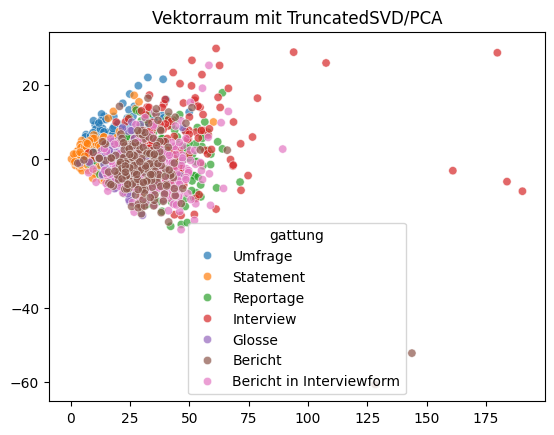

In [99]:
ax = sns.scatterplot(
    data=df,
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='tab10',
    alpha=0.7
)
ax.set(title = "Vektorraum mit TruncatedSVD/PCA")

What a mess!

In [102]:
from sklearn.manifold import TSNE

# t-SNE anwenden (auf 2D reduzieren)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

[Text(0.5, 1.0, 'Vektorraum mit TruncatedSVD/PCA')]

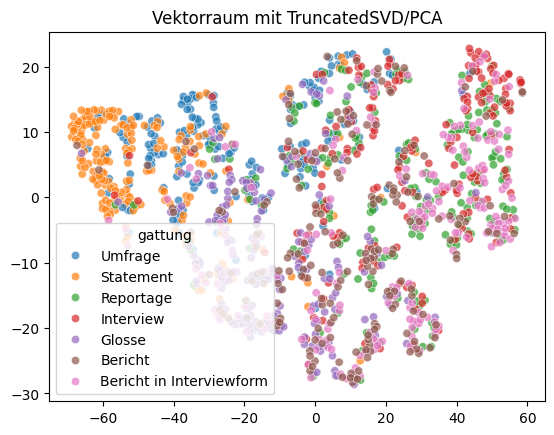

In [104]:
ax = sns.scatterplot(
    data=df,
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='tab10',
    alpha=0.7
)
ax.set(title = "Vektorraum mit TruncatedSVD/PCA")

Witzig, aber ohne wirkliche Cluster

## Bag of Words

### BoW + Naive Bayes

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [106]:
vectorizer = CountVectorizer(max_features=4000)

X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

Genauigkeit Trainingsset: 0.9320297951582868
Genauigkeit Testset: 0.5910780669144982


Overfitting!

### BoW + Logistic Regression

In [108]:
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(max_features=8000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

/root/nlp-genres/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.6654275092936803


Overfitting!

### BoW + Support Vector Machines

In [110]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

vectorizer = CountVectorizer(max_features=8000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

# model = SVC(kernel='linear', C=1.0)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Genauigkeit: {accuracy}")

Beste Parameter: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Bester Score: 0.6201117318435755


In [111]:
model = SVC(C=10, gamma="scale", kernel="rbf")
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

Genauigkeit Trainingsset: 0.9916201117318436
Genauigkeit Testset: 0.7211895910780669


Immer noch ein bisschen Overfitting, aber besser

### BoW + Decision Tree

In [112]:
from sklearn.tree import DecisionTreeClassifier

vectorizer = CountVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", dt_classifier.score(X_train, y_train))
print("Genauigkeit Testset:", dt_classifier.score(X_test, y_test))

Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.4163568773234201


Overfitting!

### BoW + Random Forest

In [113]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vorher: DecisionTreeClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1          # Nutzt alle CPU-Kerne
)
rf_classifier.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", rf_classifier.score(X_train, y_train))
print("Genauigkeit Testset:", rf_classifier.score(X_test, y_test))

Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.6505576208178439


Overfitting!

In [114]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400]},
             verbose=1)

In [98]:
print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Beste Parameter: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}
Bester Score: 0.6148603057191706


In [115]:
# Vorher: DecisionTreeClassifier
rf_classifier_best_params = RandomForestClassifier(
    n_estimators=300,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1,          # Nutzt alle CPU-Kerne
    max_features="sqrt",
)
rf_classifier_best_params.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", rf_classifier_best_params.score(X_train, y_train))
print("Genauigkeit Testset:", rf_classifier_best_params.score(X_test, y_test))

Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.6728624535315985


Overfitting

Wir haben hier bei allen Modellen ein Overfitting-Problem. Versuche es mit Dimensionsreduktion/Topic Modelling zu lösen, wie im Buch "Natural Processing in Action" beschrieben

### Dimensionsreduktion/Topic Modelling

In [177]:
from sklearn.decomposition import TruncatedSVD

# Bag of Words schnüren
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["text_stopwordless"])
y = df['gattung']

svd = TruncatedSVD(n_components=30, n_iter=100) 
columns = ['topic{}'.format(i) for i in range(svd.n_components)]
svd_topic_vectors = svd.fit_transform(X)

In [178]:
# hier sind die 16 Topics, die der Algorithmus identifiziert hat, als Dataframe
df_svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns)
df_svd_topic_vectors

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic20,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29
0,4.169890,-1.437824,-0.270297,-1.336581,-0.600724,0.175579,-0.182710,-0.269423,0.903040,-1.169538,...,-0.754805,-0.745068,-0.488934,-1.056576,0.250979,1.220683,-1.399417,-0.576206,-0.134450,0.360646
1,9.679166,0.839887,1.270819,6.773034,-1.576390,-2.917480,-1.743300,-1.070600,-1.538704,-0.237217,...,-0.312210,0.476221,1.157448,-0.331006,-0.161696,-1.013738,-0.354870,0.511080,-0.831374,-1.328191
2,8.790604,-2.080179,-3.992840,-0.456240,0.199399,1.456615,0.888769,-1.536743,-1.095746,2.008344,...,2.468090,-1.210757,0.408036,0.385778,-1.120909,-0.536884,-0.720140,0.846689,-0.659014,-0.773730
3,3.630929,0.364102,1.452645,1.923465,-0.789587,0.978202,-0.987767,0.514079,-1.057032,0.391751,...,0.635438,-0.207246,-0.064393,0.036467,-0.483672,-0.310356,-0.366262,-0.148946,0.136302,0.330158
4,11.043187,-4.667889,-0.656037,-0.780865,-2.093789,0.354931,0.409724,-1.123104,0.909396,1.708353,...,2.388331,-0.014889,-0.500895,-2.789006,0.523936,0.250878,-1.698803,0.859963,0.020754,-1.428474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,5.076468,1.573684,1.441802,-0.927944,0.599626,1.954665,0.072098,-1.062188,0.003128,-0.190476,...,0.847253,-0.268089,-0.256228,1.290770,1.013943,0.253969,0.557097,-0.669084,-0.290193,0.758292
1339,9.103117,-1.884825,0.977555,-1.632714,-1.149797,2.774365,0.615557,3.145101,1.306147,3.667843,...,-0.199079,0.422789,-0.731861,1.741012,-0.077487,-0.377413,-0.540334,-0.279240,0.098805,-1.066399
1340,10.940305,-1.250646,2.527555,-1.493650,1.279220,1.328641,-0.233947,3.900004,0.034475,1.579472,...,-0.768884,0.431615,0.043415,-0.818052,-0.685673,2.065533,-0.699594,0.273341,-0.386000,0.465516
1341,4.146989,-1.442990,-0.989048,0.767899,0.179447,-0.414223,0.134348,-0.694028,-0.695298,0.067638,...,1.198422,-0.454818,0.269339,-0.045736,0.434628,0.706724,0.085660,-0.101046,0.148162,0.102201


In [179]:
# hier werden die Terme aus dem Bag of Words angezeigt
column_nums, terms = zip(*sorted(zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys()))) 
terms[-10:]

('überwinden',
 'überwindung',
 'überzeugen',
 'überzeugt',
 'überzeugung',
 'üblichen',
 'übrig',
 'übrigens',
 'übung',
 'übungen')

In [180]:
# Hier wird aus den BoW Termen und svd componenten eine Tabelle gestrickt. In der sieht man, wie viel jeder Term zu jedem Topic beiträgt.
topic_term_matrix = pd.DataFrame(svd.components_, columns=terms, index=['topic{}'.format(i) for i in range(30)])
topic_term_matrix.head()

,10,100,1000,10000,11,12,120,1200,13,14,...,überwinden,überwindung,überzeugen,überzeugt,überzeugung,üblichen,übrig,übrigens,übung,übungen
topic0,0.001963,0.002325,0.000779,0.000427,0.000909,0.001133,0.000878,0.000583,0.003001,0.005793,...,0.000447,0.000803,0.000703,0.001854,0.000620,0.000960,0.001155,0.008640,0.000953,0.000514
topic1,0.002323,-0.005851,0.000289,0.000546,0.001159,-0.000795,0.001559,-0.000643,-0.001486,-0.006266,...,0.000565,-0.000201,0.000656,-0.000658,0.000627,0.002146,-0.001092,-0.019309,0.000498,0.001294
topic2,-0.001566,0.005491,0.001459,0.001542,0.001338,0.000282,0.002835,-0.000988,-0.001206,0.000803,...,-0.000563,-0.002174,-0.000452,-0.000400,-0.002778,-0.000982,0.001409,0.000699,0.002121,-0.000959
topic3,-0.000584,-0.000399,-0.002022,0.000645,-0.001094,-0.000775,-0.001356,-0.002120,-0.000776,-0.003757,...,0.000178,0.002342,-0.001535,-0.002415,-0.003366,-0.004316,-0.000244,0.005486,0.000699,0.000501
topic4,-0.000281,0.002545,0.001155,0.002186,-0.001747,0.000223,0.002157,-0.000734,0.001951,-0.001376,...,0.000492,0.000074,-0.001528,-0.000246,-0.002044,-0.000683,-0.000914,0.007661,-0.001708,0.001336


In [181]:
# ... hier einzelne Wörter ausprobieren
topic_term_matrix["interview"]

topic0     0.002560
topic1    -0.004322
topic2    -0.005047
topic3     0.001971
topic4    -0.000448
topic5    -0.005380
topic6     0.005611
topic7    -0.004724
topic8    -0.006842
topic9     0.002933
topic10    0.000491
topic11   -0.004391
topic12    0.004012
topic13    0.000577
topic14   -0.000097
topic15   -0.002178
topic16    0.002783
topic17   -0.005832
topic18    0.005656
topic19    0.008810
topic20    0.002240
topic21    0.006438
topic22    0.004694
topic23    0.001346
topic24   -0.004045
topic25    0.016677
topic26    0.011993
topic27    0.010205
topic28   -0.008968
topic29   -0.006584
Name: interview, dtype: float64

In [182]:
# und die performance?
X_train_16d, X_test_16d, y_train_16d, y_test_16d = train_test_split(df_svd_topic_vectors, 
                                                                    y, 
                                                                    test_size=0.2, 
                                                                    random_state=42)


In [183]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_lsa = LinearDiscriminantAnalysis(n_components=1)
model = lda_lsa.fit(X_train_16d, y_train_16d)

In [184]:
print("Genauigkeit Trainingsset:", model.score(X_train_16d, y_train_16d))
print("Genauigkeit Testset:", model.score(X_test_16d, y_test_16d))

Genauigkeit Trainingsset: 0.6042830540037244
Genauigkeit Testset: 0.5762081784386617


Das hat nicht so gut geklappt. Versuchen wir das SVD-Modell von oben

In [186]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_16d, y_train_16d)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Beste Parameter: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Bester Score: 0.5931098696461824


In [185]:
model = SVC(C=1, gamma="scale", kernel="rbf")
model.fit(X_train_16d, y_train_16d)

print("Genauigkeit Trainingsset:", model.score(X_train_16d, y_train_16d))
print("Genauigkeit Testset:", model.score(X_test_16d, y_test_16d))

Genauigkeit Trainingsset: 0.7067039106145251
Genauigkeit Testset: 0.6096654275092936


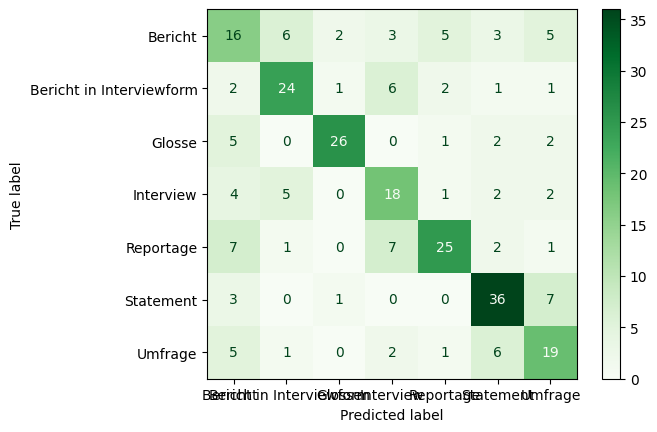

In [190]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ... Matrix erstellen
y_pred = model.predict(X_test_16d)
cm = confusion_matrix(y_test_16d, y_pred)

# ... und visualisieren
class_names = np.unique(y_test_16d)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.show()

## TF-IDF

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

### TF-IDF + Naive Bayes

In [103]:
# TF-IDF statt reinen Wortzählens
vectorizer = TfidfVectorizer(max_features=2000)  # 👈 Geändert
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Genauigkeit:", accuracy_score(y_test, y_pred))

Genauigkeit: 0.44485294117647056


### TF-IDF + Logistic Regreggion

In [113]:
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit: {accuracy}")

Genauigkeit: 0.6507352941176471


### TF-IDF + SVM

In [116]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Beste Parameter: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Bester Score: 0.6525577218696255


### TF-IDF + Random Forest

In [117]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vorher: DecisionTreeClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1          # Nutzt alle CPU-Kerne
)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6176470588235294


In [118]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Beste Parameter: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}
Bester Score: 0.6240684088499258
